<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-exploration" data-toc-modified-id="Data-exploration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data exploration</a></span></li><li><span><a href="#XGBoost-model" data-toc-modified-id="XGBoost-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>XGBoost model</a></span><ul class="toc-item"><li><span><a href="#Hyperparameter-tuning-with-Hyperopt" data-toc-modified-id="Hyperparameter-tuning-with-Hyperopt-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Hyperparameter tuning with Hyperopt</a></span></li><li><span><a href="#Model-fitting" data-toc-modified-id="Model-fitting-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Model fitting</a></span><ul class="toc-item"><li><span><a href="#Clicks" data-toc-modified-id="Clicks-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Clicks</a></span><ul class="toc-item"><li><span><a href="#Saving-the-model" data-toc-modified-id="Saving-the-model-2.2.1.1"><span class="toc-item-num">2.2.1.1&nbsp;&nbsp;</span>Saving the model</a></span></li></ul></li><li><span><a href="#Carts" data-toc-modified-id="Carts-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Carts</a></span><ul class="toc-item"><li><span><a href="#Saving-the-model" data-toc-modified-id="Saving-the-model-2.2.2.1"><span class="toc-item-num">2.2.2.1&nbsp;&nbsp;</span>Saving the model</a></span></li></ul></li><li><span><a href="#Orders" data-toc-modified-id="Orders-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Orders</a></span><ul class="toc-item"><li><span><a href="#Saving-the-model" data-toc-modified-id="Saving-the-model-2.2.3.1"><span class="toc-item-num">2.2.3.1&nbsp;&nbsp;</span>Saving the model</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Validation-check" data-toc-modified-id="Validation-check-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Validation check</a></span><ul class="toc-item"><li><span><a href="#Submission-XGB-SCORE" data-toc-modified-id="Submission-XGB-SCORE-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Submission XGB SCORE</a></span></li></ul></li><li><span><a href="#Misc" data-toc-modified-id="Misc-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Misc</a></span></li></ul></div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_tree
from lightgbm import LGBMClassifier, plot_tree #LGBMRanker
import math
import pickle
import statsmodels.api as sm


import xgboost as xgb

In [3]:
seed=1234

In [4]:
# file = open("type2id.pkl",'rb')
# object_file = pickle.load(file)

In [5]:
# file_name = "otto_xgb_model_13_cv.pkl"

In [6]:
df=pd.read_parquet('train_sample_full_cv_3targets_experimental_reduced.parquet')#train_sample_full_cv_hidden_targets_float
# valid=pd.read_parquet('valid_sample_full_cv_3targets_experimental.parquet')

In [7]:
# df=df[df['MIN_TOP20']<=60]
# valid=valid[valid['MIN_TOP20']<=40]

In [8]:
# df=pd.concat([df,valid])

In [9]:
# del valid

In [10]:
df.columns=[x.lower() for x in df.columns]
# valid.columns=[x.lower() for x in valid.columns]

In [11]:
# sessions_with_orders=pd.DataFrame(df.groupby('session_id')['target'].sum()).reset_index()
# sessions_with_orders=sessions_with_orders[sessions_with_orders['target']>0]
# df=df.merge(sessions_with_orders['session_id'], how='inner', on='session_id')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20574641 entries, 0 to 20574640
Data columns (total 51 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   target                          float64
 1   target_clicks                   float64
 2   target_carts                    float64
 3   target_orders                   float64
 4   session_id                      float64
 5   aid                             float64
 6   min_top20                       float64
 7   avg_top20                       float64
 8   max_top20                       float64
 9   in_session                      float64
 10  in_session_clicked              float64
 11  in_session_carted               float64
 12  in_session_ordered              float64
 13  in_session_score                float64
 14  in_session_score_time_weighted  float64
 15  times_in_top20                  float64
 16  times_in_top20_last_week        float64
 17  min_order_hours_from_clic

In [13]:
df.head()

,target,target_clicks,target_carts,target_orders,session_id,aid,min_top20,avg_top20,max_top20,in_session,...,number_orders,first_seen,last_seen,first_bought,last_bought,bought_overall,seen_overall,num_clicks_same_day,num_carts_same_day,num_orders_same_day
0,0.0,0.0,0.0,0.0,8938465.0,564685.0,16.0,16.0,16.0,0.0,...,0.0,491.619506,124.111059,482.864629,124.111059,6.0,39.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,8938465.0,565316.0,50.0,50.0,50.0,0.0,...,0.0,502.813942,74.272007,502.018061,74.285707,36.0,151.0,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,8938465.0,571687.0,98.0,98.0,98.0,0.0,...,0.0,492.177236,27.309626,368.904207,203.731431,6.0,89.0,4.0,0.0,0.0
3,0.0,0.0,0.0,0.0,8938465.0,573913.0,99.0,99.0,99.0,0.0,...,0.0,503.908608,1.141526,495.855277,14.712022,30.0,654.0,7.0,2.0,2.0
4,0.0,0.0,0.0,0.0,8938465.0,602226.0,63.0,63.0,63.0,0.0,...,0.0,490.982738,31.480027,489.757147,175.569146,8.0,106.0,1.0,0.0,0.0


In [14]:
df['null_flag']=(df['avg_order_hours_from_click_avg']<99999).apply(int)
df['in_session_carted_not_ordered']=((df['in_session_carted']>0)&(df['in_session_ordered']==0)).apply(int)
df['in_session_clicked_not_carted']=((df['in_session_clicked']>0)&(df['in_session_carted']==0)).apply(int)

df['in_session_clicked_not_ordered']=((df['in_session_clicked']>0)&(df['in_session_ordered']==0)).apply(int)
df['min_top20_x_in_session_score_time_weighted']=df['min_top20']*df['in_session_score_time_weighted']
df['avg_top20_x_in_session_score_time_weighted']=df['avg_top20']*df['in_session_score_time_weighted']
df['num_clicks_same_day_x_num_carts_same_day']=df['num_clicks_same_day']*df['num_carts_same_day']
df['num_clicks_same_day_x_num_orders_same_day']=df['num_clicks_same_day']*df['num_orders_same_day']
df['num_carts_same_day_x_num_orders_same_day']=df['num_carts_same_day']*df['num_orders_same_day']

# valid['null_flag']=(valid['avg_order_hours_from_click_avg']<99999).apply(int)
# valid['in_session_carted_not_ordered']=((valid['in_session_carted']>0)&(valid['in_session_ordered']==0)).apply(int)
# valid['in_session_clicked_not_carted']=((valid['in_session_clicked']>0)&(valid['in_session_carted']==0)).apply(int)

In [15]:
df['null_flag'].value_counts(normalize=True)

1    0.751868
0    0.248132
Name: null_flag, dtype: float64

In [16]:
df['target'].value_counts()

0.0    20552278
1.0       22363
Name: target, dtype: int64

In [17]:
# rand=np.random.randint(1, 11, df.shape[0])

# train_mask=(df['sess_days_till_test']+df['sess_duration']/24)>0#rand<=8
# valid_mask=(df['sess_days_till_test']+df['sess_duration']/24)>0#rand>8

In [18]:
# df[train_mask]['target'].value_counts()

In [19]:
# df[valid_mask]['target'].value_counts()

In [20]:
col_target='target'
col_exclude=[
'session_id',
'aid',
# 'num_times_ordered_overall',
'number_carts_orders',
'number_carts',
'number_orders',
'sess_days_till_test',
'sess_dayofmonth',
# 'in_session',
# 'in_session_clicked',
# 'in_session_carted',
#  'in_session_ordered',
#  'in_session_score',
'first_seen',
'first_bought',

'target_clicks',
'target_carts',
'target_orders',
col_target,]

In [21]:
# df[col_target]=df[col_target].apply(int)

# Data exploration

In [22]:
col_preds=[col for col in df.columns[3:] if col not in col_exclude]

In [23]:
len(col_preds)

47

In [24]:
col_preds

['min_top20',
 'avg_top20',
 'max_top20',
 'in_session',
 'in_session_clicked',
 'in_session_carted',
 'in_session_ordered',
 'in_session_score',
 'in_session_score_time_weighted',
 'times_in_top20',
 'times_in_top20_last_week',
 'min_order_hours_from_click_avg',
 'avg_order_hours_from_click_avg',
 'avg_num_sessions_ordered',
 'sum_num_sessions_ordered',
 'avg_num_occured_overall',
 'sum_num_occured_overall',
 'last_num_sessions_ordered',
 'last_hour_num_sessions_ordered',
 'num_times_ordered_overall',
 'sess_num_events',
 'sess_num_clicks',
 'sess_num_carts',
 'sess_num_orders',
 'sess_num_clicks_last_hour',
 'sess_num_carts_last_hour',
 'sess_num_orders_last_hour',
 'sess_duration',
 'sess_minute',
 'sess_hour',
 'sess_dayofweek',
 'last_seen',
 'last_bought',
 'bought_overall',
 'seen_overall',
 'num_clicks_same_day',
 'num_carts_same_day',
 'num_orders_same_day',
 'null_flag',
 'in_session_carted_not_ordered',
 'in_session_clicked_not_carted',
 'in_session_clicked_not_ordered',
 'm

# XGBoost model

## Hyperparameter tuning with Hyperopt

In [25]:
# from hyperopt import fmin, tpe, hp, anneal, Trials, STATUS_OK

# sample_train=valid.sample(250000)
# sample_valid=valid.sample(100000)

# space={'max_depth': hp.quniform("max_depth", 3, 6, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 100,
#         'seed': 0
#     }

# def objective(space):
#     clf=xgb.XGBClassifier(
#                     n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
#                     reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
#                     colsample_bytree=int(space['colsample_bytree']))
    
#     evaluation = [( sample_train[col_preds], sample_train[col_target]), ( sample_valid[col_preds], sample_valid[col_target])]
    
#     clf.fit(sample_train[col_preds], sample_train[col_target],
#             eval_set=evaluation, eval_metric="auc",
#             early_stopping_rounds=10,verbose=False)
    

#     pred = clf.predict_proba(sample_valid[col_preds])[:, 1]
#     gini = mofr.metrics.gini(sample_valid[col_target], pred)
#     print ("SCORE:", gini)
#     return {'loss': -gini, 'status': STATUS_OK }

# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 33,
#                         trials = trials)

# del sample_train
# del sample_valid

# hyperparams_name = "best_hyperparams_cv.pkl"

# # save
# pickle.dump(best_hyperparams, open(hyperparams_name, "wb"))

## Model fitting

In [26]:
hyperparams_name = "best_hyperparams_cv.pkl"
best_hyperparams= pickle.load(open(hyperparams_name, "rb"))

In [27]:
best_hyperparams['max_depth']=int(best_hyperparams['max_depth'])
best_hyperparams['max_depth']=4
best_hyperparams

{'colsample_bytree': 0.8401480036351863,
 'gamma': 4.533881831368805,
 'max_depth': 4,
 'min_child_weight': 6.0,
 'reg_alpha': 44.0,
 'reg_lambda': 0.6267589435952949}

In [28]:
# train=df[train_mask]#&(df['null_flag']==1)
# print(train['session_id'].max())
# train[col_target].value_counts()

### Clicks

In [29]:
col_target='target_clicks'

In [30]:
# train['target_clicks'].value_counts()
df['target_clicks'].value_counts()

0.0    20517964
1.0       56677
Name: target_clicks, dtype: int64

In [31]:
xgb_model_clicks = XGBClassifier(max_depth=4, seed=seed, colsample_bytree=0.5, gamma=1, min_child_weight=5, n_estimators=100)
# xgb_model = XGBClassifier(**best_hyperparams)##

xgb_model_clicks.fit(df.loc[:, col_preds], df['target_clicks'], verbose=0, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1234, ...)

In [32]:
df['XGB_SCORE_CLICKS']=xgb_model_clicks.predict_proba(df[col_preds])[:, 1]
# train['XGB_SCORE_CLICKS']=xgb_model_clicks.predict_proba(train[col_preds])[:, 1]
# valid['XGB_SCORE_CLICKS']=xgb_model_clicks.predict_proba(valid[col_preds])[:, 1]

In [33]:
print('The Lift on the train set is: '+ str(mofr.metrics.lift(df[col_target], df['XGB_SCORE_CLICKS'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(df[col_target].apply(int), df['XGB_SCORE_CLICKS'])))
# print('The accuracy on the train set is: '+ str(mofr.metrics.accuracy_score(train[col_target].apply(int), train['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
print('\n')
# print('The Lift on the valid set is: '+ str(mofr.metrics.lift(valid[col_target], valid['XGB_SCORE_CLICKS'])))
# print('The gini on the valid set is: '+ str(mofr.metrics.gini(valid[col_target].apply(int), valid['XGB_SCORE_CLICKS'])))
# # print('The accuracy on the valid set is: '+ str(mofr.metrics.accuracy_score(df[valid_mask][col_target].apply(int), df[valid_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
# print('\n')

The Lift on the train set is: 8.229793790613963
The gini on the train set is: 0.8825755911306643




In [34]:
# from mofr.basic_evaluators.ROCCurve import ROCCurveEvaluator
# df['one']=1

# rce=ROCCurveEvaluator()
# rce.d(df[valid_mask]).t([(col_target,'one')]).s(['XGB_SCORE_CLICKS'])
# rce.get_graph()

# del df['one']

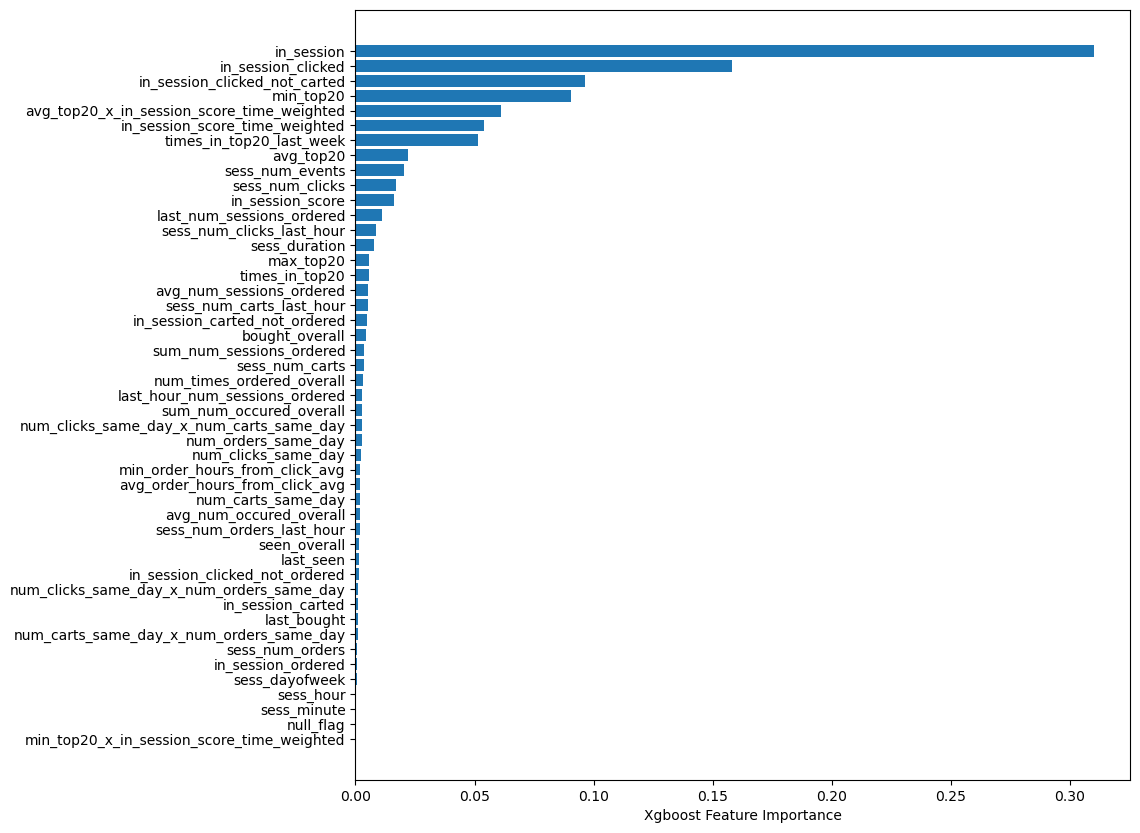

In [35]:
sorted_idx = xgb_model_clicks.feature_importances_.argsort()
order_ = []
for i in sorted_idx:
  order_.append(xgb_model_clicks.feature_names_in_[i])
plt.figure(figsize=(10, 10))
fig = plt.barh(order_, xgb_model_clicks.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

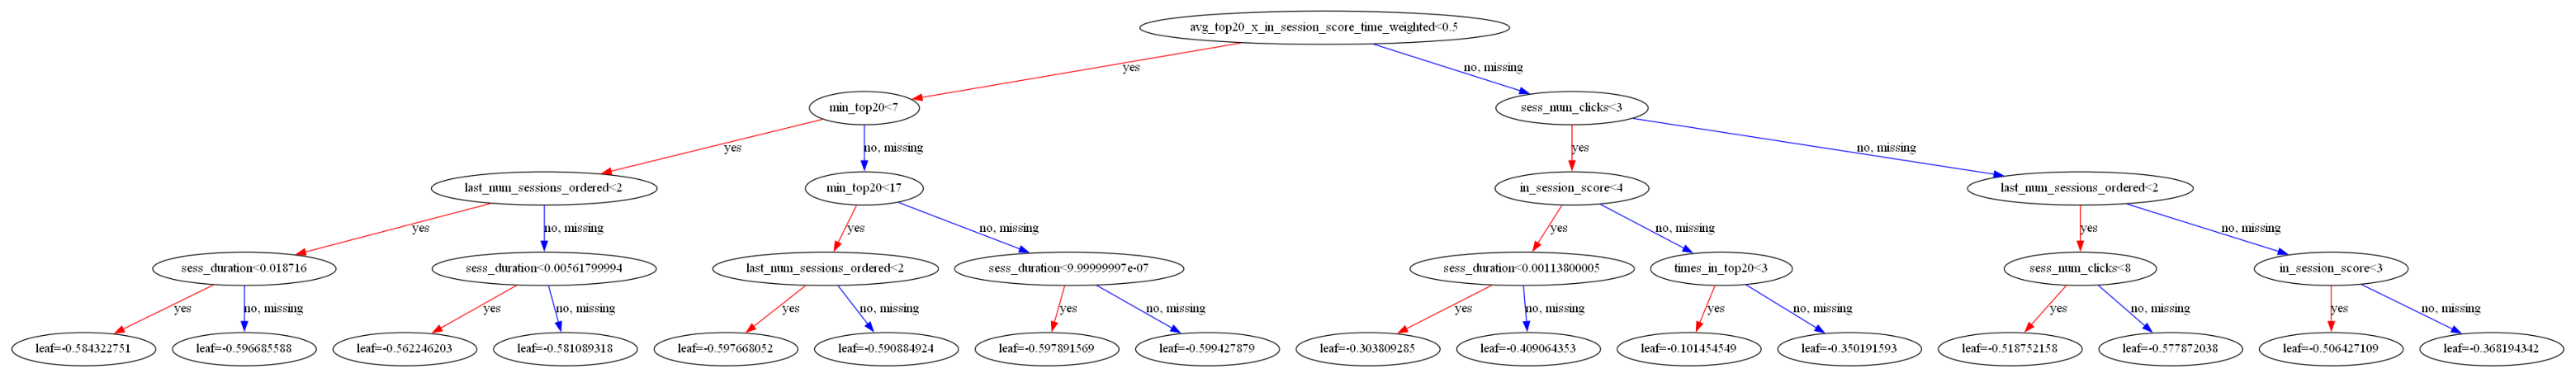

In [36]:
import os
os.environ["PATH"] += os.pathsep + 'c:/Program Files/Graphviz/bin/'

from xgboost import plot_tree
plt.rcParams["figure.figsize"] = (40,40)
plot_tree(xgb_model_clicks)
plt.show()

In [37]:
# results=[]
# for col in col_preds:
#     results.append((col, np.abs(mofr.metrics.gini(df[valid_mask][col_target], df[valid_mask][col]))))
  
# pd.DataFrame(results, columns=['Predictor', 'GINI']).sort_values(by='GINI', ascending=False)[0:30]

#### Saving the model

In [38]:
file_name = "otto_xgb_model_14_clicks_cv_reduced.pkl"

# save
pickle.dump(xgb_model_clicks, open(file_name, "wb"))

# # load
# #xgb_model= pickle.load(open(file_name, "rb"))

In [39]:
sample=df.sample(100000)
results=[]
for col in col_preds:
    results.append((col, mofr.metrics.gini(sample['target_clicks'], sample[col].fillna(-999))))

pd.DataFrame(results, columns=['Predictor', 'GINI']).sort_values(by='GINI', ascending=False)

,Predictor,GINI
10,times_in_top20_last_week,0.636897
17,last_num_sessions_ordered,0.510940
13,avg_num_sessions_ordered,0.500924
8,in_session_score_time_weighted,0.497700
7,in_session_score,0.495932
3,in_session,0.495511
43,avg_top20_x_in_session_score_time_weighted,0.494398
4,in_session_clicked,0.484233
41,in_session_clicked_not_ordered,0.476611
15,avg_num_occured_overall,0.458783


In [40]:
del sample

### Carts

In [41]:
# train['target_carts'].value_counts()
df['target_carts'].value_counts()

0.0    20557962
1.0       16679
Name: target_carts, dtype: int64

In [42]:
xgb_model_carts = XGBClassifier(max_depth=4, seed=seed, colsample_bytree=0.5, gamma=1, min_child_weight=5, n_estimators=100)
# xgb_model = XGBClassifier(**best_hyperparams)##

xgb_model_carts.fit(df.loc[:, col_preds], df['target_carts'], verbose=0, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1234, ...)

In [43]:
df['XGB_SCORE_CARTS']=xgb_model_carts.predict_proba(df[col_preds])[:, 1]
# train['XGB_SCORE_CARTS']=xgb_model_carts.predict_proba(train[col_preds])[:, 1]
# valid['XGB_SCORE_CARTS']=xgb_model_carts.predict_proba(valid[col_preds])[:, 1]

In [44]:
print('The Lift on the train set is: '+ str(mofr.metrics.lift(df[col_target], df['XGB_SCORE_CARTS'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(df[col_target].apply(int), df['XGB_SCORE_CARTS'])))
# print('The accuracy on the train set is: '+ str(mofr.metrics.accuracy_score(train[col_target].apply(int), train['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
# print('\n')
# print('The Lift on the valid set is: '+ str(mofr.metrics.lift(valid[col_target], valid['XGB_SCORE_CARTS'])))
# print('The gini on the valid set is: '+ str(mofr.metrics.gini(valid[col_target].apply(int), valid['XGB_SCORE_CARTS'])))
# # print('The accuracy on the valid set is: '+ str(mofr.metrics.accuracy_score(df[valid_mask][col_target].apply(int), df[valid_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
# print('\n')

The Lift on the train set is: 6.832577920879977
The gini on the train set is: 0.7469611294732972


In [45]:
# from mofr.basic_evaluators.ROCCurve import ROCCurveEvaluator
# df['one']=1

# rce=ROCCurveEvaluator()
# rce.d(df[valid_mask]).t([(col_target,'one')]).s(['XGB_SCORE_CARTS'])
# rce.get_graph()

# del df['one']

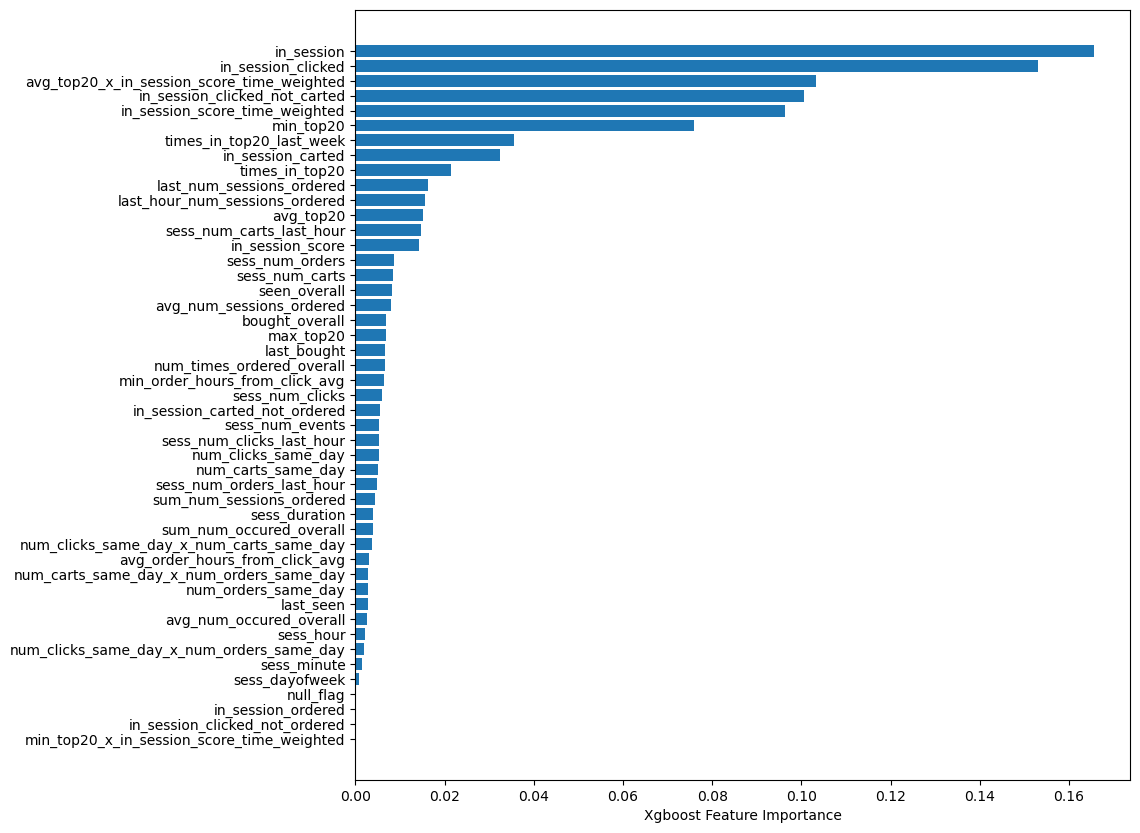

In [46]:
sorted_idx = xgb_model_carts.feature_importances_.argsort()
order_ = []
for i in sorted_idx:
  order_.append(xgb_model_carts.feature_names_in_[i])
plt.figure(figsize=(10, 10))
fig = plt.barh(order_, xgb_model_carts.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

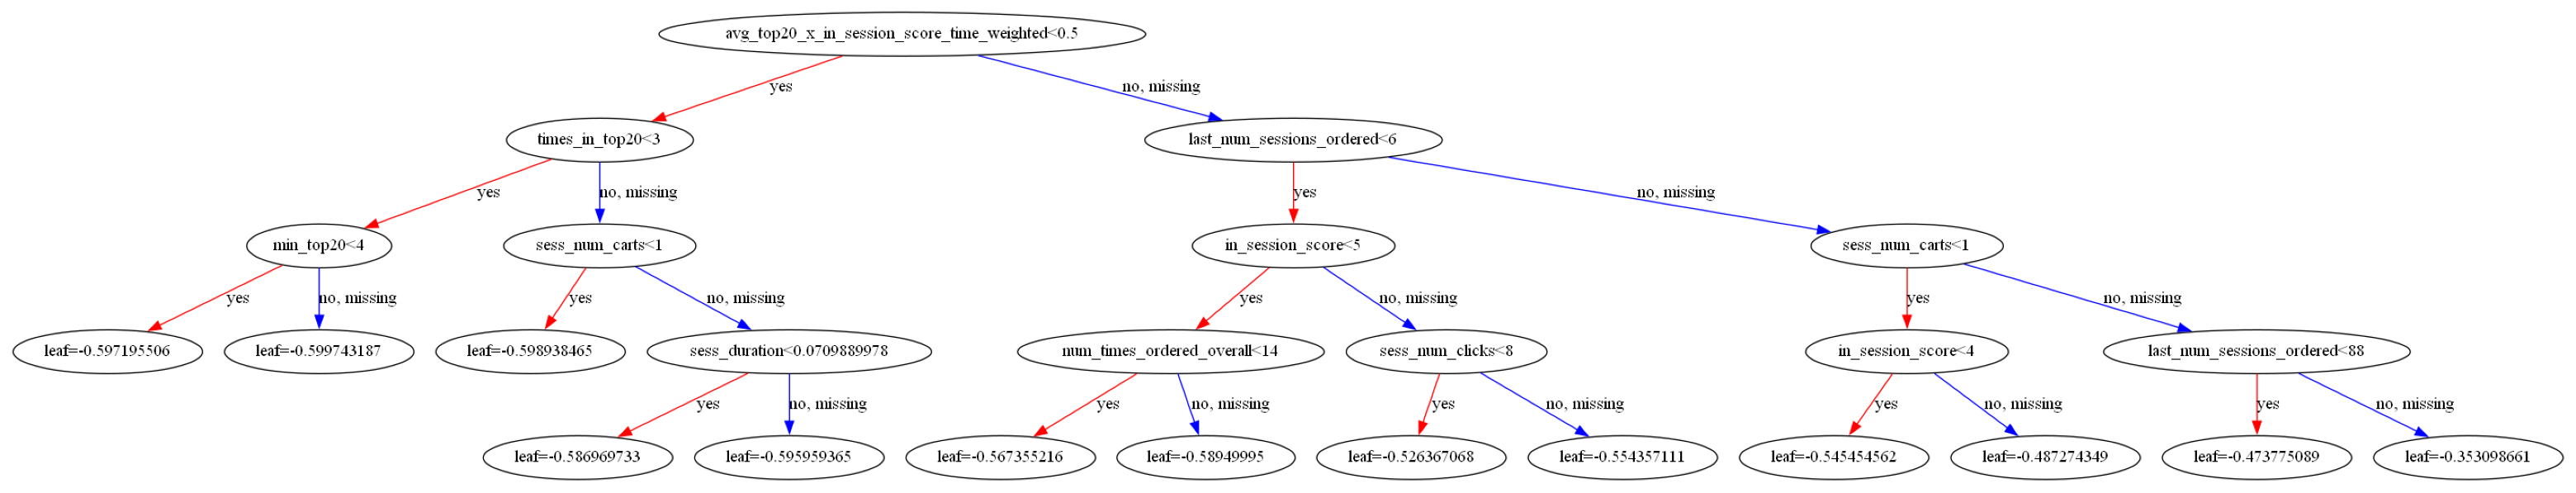

In [47]:
import os
os.environ["PATH"] += os.pathsep + 'c:/Program Files/Graphviz/bin/'

from xgboost import plot_tree
plt.rcParams["figure.figsize"] = (40,40)
plot_tree(xgb_model_carts)
plt.show()

#### Saving the model

In [48]:
col_target='target_carts'

In [49]:
file_name = "otto_xgb_model_14_carts_cv_reduced.pkl"

# save
pickle.dump(xgb_model_carts, open(file_name, "wb"))

# # load
# #xgb_model= pickle.load(open(file_name, "rb"))

In [50]:
sample=df.sample(100000)
results=[]
for col in col_preds:
    results.append((col, mofr.metrics.gini(sample['target_carts'], sample[col].fillna(-999))))

pd.DataFrame(results, columns=['Predictor', 'GINI']).sort_values(by='GINI', ascending=False)

,Predictor,GINI
18,last_hour_num_sessions_ordered,0.680897
13,avg_num_sessions_ordered,0.679405
14,sum_num_sessions_ordered,0.673732
16,sum_num_occured_overall,0.661705
10,times_in_top20_last_week,0.647307
15,avg_num_occured_overall,0.644347
17,last_num_sessions_ordered,0.563405
8,in_session_score_time_weighted,0.494514
7,in_session_score,0.493141
43,avg_top20_x_in_session_score_time_weighted,0.491985


In [51]:
del sample

### Orders

In [52]:
col_target='target_orders'

In [53]:
# train['target_orders'].value_counts()
df['target_orders'].value_counts()

0.0    20563821
1.0       10820
Name: target_orders, dtype: int64

In [54]:
xgb_model_orders = XGBClassifier(max_depth=4, seed=seed, colsample_bytree=0.5, gamma=1, min_child_weight=5, n_estimators=100)
# xgb_model = XGBClassifier(**best_hyperparams)##

xgb_model_orders.fit(df.loc[:, col_preds], df['target_orders'], verbose=0, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1234, ...)

In [55]:
df['XGB_SCORE_ORDERS']=xgb_model_orders.predict_proba(df[col_preds])[:, 1]
# train['XGB_SCORE_ORDERS']=xgb_model_orders.predict_proba(train[col_preds])[:, 1]
# valid['XGB_SCORE_ORDERS']=xgb_model_orders.predict_proba(valid[col_preds])[:, 1]

In [56]:
print('The Lift on the train set is: '+ str(mofr.metrics.lift(df[col_target], df['XGB_SCORE_ORDERS'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(df[col_target].apply(int), df['XGB_SCORE_ORDERS'])))
# print('The accuracy on the train set is: '+ str(mofr.metrics.accuracy_score(train[col_target].apply(int), train['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
# print('\n')
# print('The Lift on the valid set is: '+ str(mofr.metrics.lift(valid[col_target], valid['XGB_SCORE_ORDERS'])))
# print('The gini on the valid set is: '+ str(mofr.metrics.gini(valid[col_target].apply(int), valid['XGB_SCORE_ORDERS'])))
# # print('The accuracy on the valid set is: '+ str(mofr.metrics.accuracy_score(df[valid_mask][col_target].apply(int), df[valid_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
# print('\n')

The Lift on the train set is: 9.561936773046604
The gini on the train set is: 0.9665348677614773


In [57]:
# from mofr.basic_evaluators.ROCCurve import ROCCurveEvaluator
# df['one']=1

# rce=ROCCurveEvaluator()
# rce.d(df[valid_mask]).t([(col_target,'one')]).s(['XGB_SCORE_ORDERS'])
# rce.get_graph()

# del df['one']

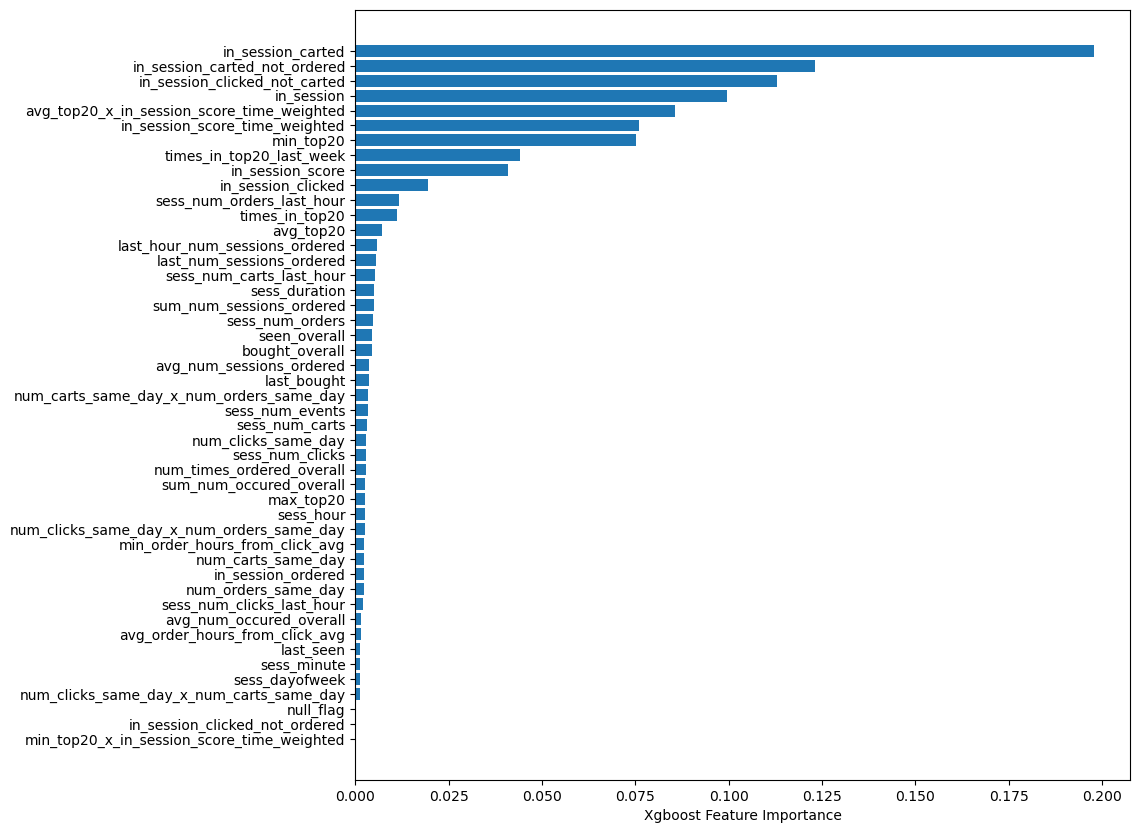

In [58]:
sorted_idx = xgb_model_orders.feature_importances_.argsort()
order_ = []
for i in sorted_idx:
  order_.append(xgb_model_orders.feature_names_in_[i])
plt.figure(figsize=(10, 10))
fig = plt.barh(order_, xgb_model_orders.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

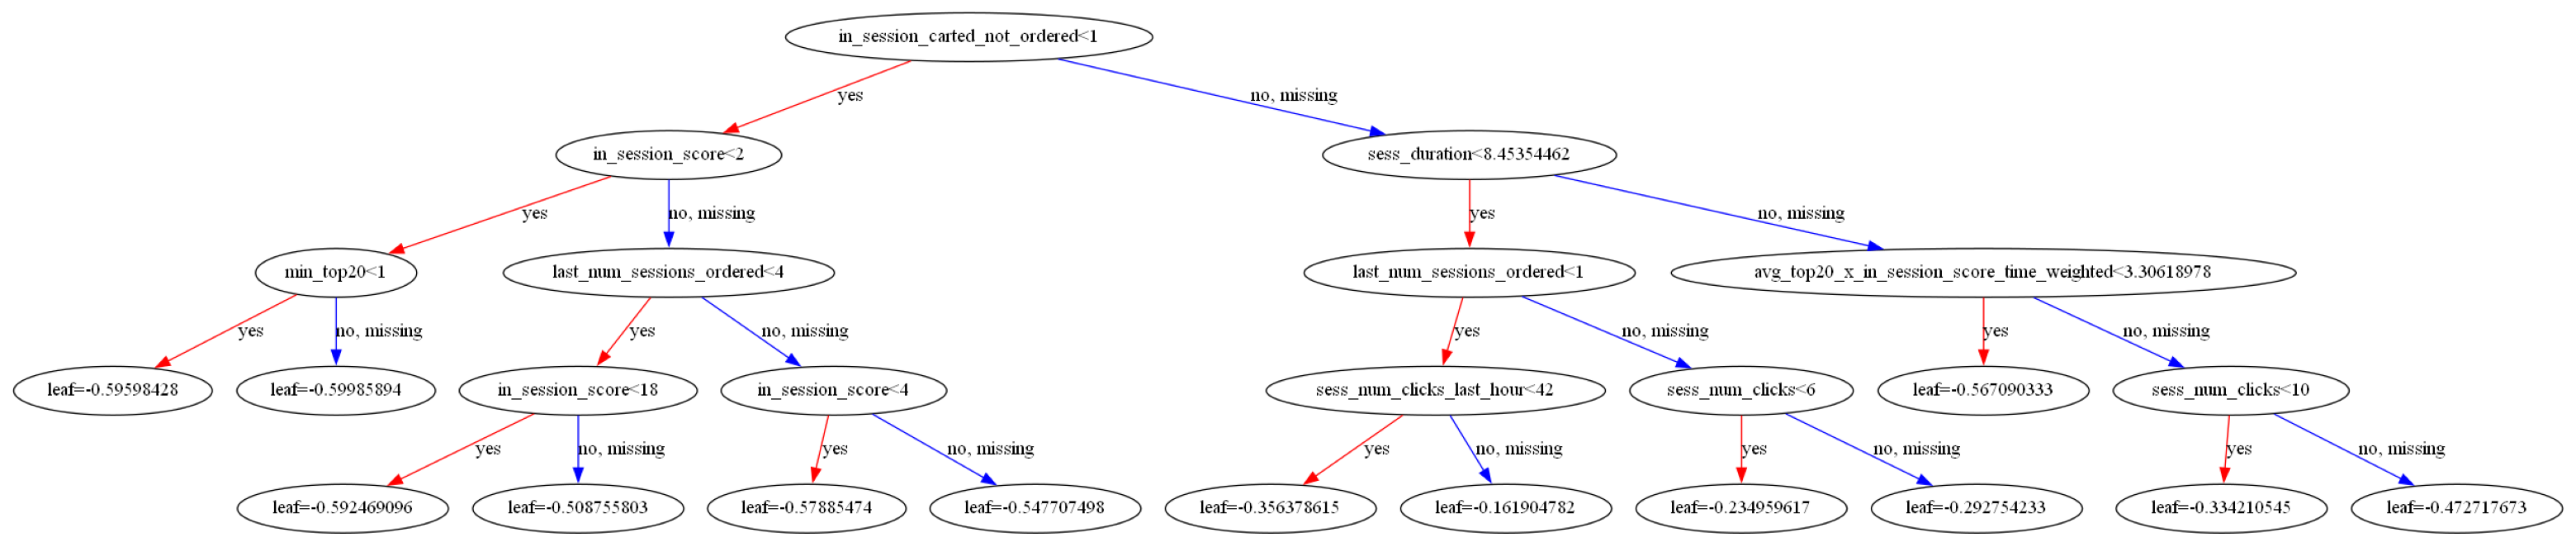

In [59]:
import os
os.environ["PATH"] += os.pathsep + 'c:/Program Files/Graphviz/bin/'

from xgboost import plot_tree
plt.rcParams["figure.figsize"] = (40,40)
plot_tree(xgb_model_orders)
plt.show()

In [60]:
# results=[]
# for col in col_preds:
#     results.append((col, np.abs(mofr.metrics.gini(df[valid_mask][col_target], df[valid_mask][col]))))
  
# pd.DataFrame(results, columns=['Predictor', 'GINI']).sort_values(by='GINI', ascending=False)[0:30]

#### Saving the model

In [61]:
file_name = "otto_xgb_model_14_orders_cv_reduced.pkl"

# save
pickle.dump(xgb_model_orders, open(file_name, "wb"))

# # load
# #xgb_model= pickle.load(open(file_name, "rb"))

In [62]:
sample=df.sample(100000)
results=[]
for col in col_preds:
    results.append((col, mofr.metrics.gini(sample[col_target], sample[col].fillna(-999))))

pd.DataFrame(results, columns=['Predictor', 'GINI']).sort_values(by='GINI', ascending=False)

,Predictor,GINI
8,in_session_score_time_weighted,0.889140
7,in_session_score,0.887723
43,avg_top20_x_in_session_score_time_weighted,0.884520
3,in_session,0.880351
4,in_session_clicked,0.816731
10,times_in_top20_last_week,0.815480
18,last_hour_num_sessions_ordered,0.810748
41,in_session_clicked_not_ordered,0.795615
14,sum_num_sessions_ordered,0.789325
16,sum_num_occured_overall,0.777266


In [63]:
del sample

# Validation check

In [64]:
del df
# del train

In [65]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_tree
import math
import pickle


import xgboost as xgb

In [66]:
file_name_clicks = "otto_xgb_model_14_clicks_cv_reduced.pkl"
file_name_carts = "otto_xgb_model_14_carts_cv_reduced.pkl"
file_name_orders = "otto_xgb_model_14_orders_cv_reduced.pkl"


# load
xgb_model_clicks= pickle.load(open(file_name_clicks, "rb"))
xgb_model_carts= pickle.load(open(file_name_carts, "rb"))
xgb_model_orders= pickle.load(open(file_name_orders, "rb"))

In [67]:
col_target='target'

In [68]:
valid=pd.read_parquet('valid_sample_full_cv_3targets_experimental.parquet')
valid.columns=[x.lower() for x in valid.columns]
valid['null_flag']=(valid['avg_order_hours_from_click_avg']<99999).apply(int)
valid['in_session_carted_not_ordered']=((valid['in_session_carted']>0)&(valid['in_session_ordered']==0)).apply(int)
valid['in_session_clicked_not_carted']=((valid['in_session_clicked']>0)&(valid['in_session_carted']==0)).apply(int)

valid['in_session_clicked_not_ordered']=((valid['in_session_clicked']>0)&(valid['in_session_ordered']==0)).apply(int)
valid['min_top20_x_in_session_score_time_weighted']=valid['min_top20']*valid['in_session_score_time_weighted']
valid['avg_top20_x_in_session_score_time_weighted']=valid['avg_top20']*valid['in_session_score_time_weighted']
valid['num_clicks_same_day_x_num_carts_same_day']=valid['num_clicks_same_day']*valid['num_carts_same_day']
valid['num_clicks_same_day_x_num_orders_same_day']=valid['num_clicks_same_day']*valid['num_orders_same_day']
valid['num_carts_same_day_x_num_orders_same_day']=valid['num_carts_same_day']*valid['num_orders_same_day']

valid['XGB_SCORE_CLICKS']=xgb_model_clicks.predict_proba(valid[xgb_model_clicks.feature_names_in_])[:, 1]
valid['XGB_SCORE_CARTS']=xgb_model_carts.predict_proba(valid[xgb_model_carts.feature_names_in_])[:, 1]
valid['XGB_SCORE_ORDERS']=xgb_model_orders.predict_proba(valid[xgb_model_orders.feature_names_in_])[:, 1]

In [69]:
valid.head()

,target,target_clicks,target_carts,target_orders,session_id,aid,min_top20,avg_top20,max_top20,in_session,...,in_session_clicked_not_carted,in_session_clicked_not_ordered,min_top20_x_in_session_score_time_weighted,avg_top20_x_in_session_score_time_weighted,num_clicks_same_day_x_num_carts_same_day,num_clicks_same_day_x_num_orders_same_day,num_carts_same_day_x_num_orders_same_day,XGB_SCORE_CLICKS,XGB_SCORE_CARTS,XGB_SCORE_ORDERS
0,0.0,0.0,0.0,0.0,11098546.0,605.0,9.0,50.000000,91.0,0.0,...,0,0,0.0,0.0,9.0,9.0,1.0,0.000059,0.000111,0.000031
1,0.0,0.0,0.0,0.0,11098546.0,665.0,71.0,71.000000,71.0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.000075,0.000018,0.000009
2,0.0,0.0,0.0,0.0,11098546.0,1089.0,16.0,45.666667,82.0,0.0,...,0,0,0.0,0.0,127.0,0.0,0.0,0.000137,0.000047,0.000021
3,0.0,0.0,0.0,0.0,11098546.0,1303.0,35.0,60.500000,87.0,0.0,...,0,0,0.0,0.0,160.0,0.0,0.0,0.000122,0.000066,0.000044
4,0.0,0.0,0.0,0.0,11098546.0,1398.0,15.0,15.000000,15.0,0.0,...,0,0,0.0,0.0,NaN,NaN,NaN,0.000197,0.000203,0.000028


In [70]:
valid[col_target].value_counts()

0.0    28769561
1.0       38983
Name: target, dtype: int64

In [71]:
# coverage=(pd.DataFrame(df.groupby('session_id')[col_target].apply(np.sum)).reset_index()).merge(df.groupby('session_id')[['number_carts_orders','number_carts', 'number_orders']].apply(np.mean), how='inner', on='session_id')
# target_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target'])/np.sum(coverage[coverage['number_carts_orders']>0]['number_carts_orders'].apply(lambda x: min([20,x])))
# # target_avg_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target']/coverage[coverage['number_carts_orders']>0]['number_carts_orders'])
# target_avg_coverage_carts=np.sum(coverage[coverage['number_carts']>0]['target'])/np.sum(coverage[coverage['number_carts']>0]['number_carts'].apply(lambda x: min([20,x])))
# target_avg_coverage_orders=np.sum(coverage[coverage['number_orders']>0]['target'])/np.sum(coverage[coverage['number_orders']>0]['number_orders'].apply(lambda x: min([20,x])))

# print(f'The coverage of the target on the train set is: {target_coverage}')
# print(f'The mean coverage of carts on the train set is: {target_avg_coverage_carts}')
# print(f'The mean coverage of orders on the train set is: {target_avg_coverage_orders}')
# print(f'Max score possible with this set is: {0.1*0.5+0.3*target_avg_coverage_carts+0.6*target_avg_coverage_orders}')

In [72]:
# coverage=(pd.DataFrame(valid.groupby('session_id')[col_target].apply(np.sum)).reset_index()).merge(valid.groupby('session_id')[['number_carts_orders','number_carts', 'number_orders']].apply(np.mean), how='inner', on='session_id')
# target_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target'])/np.sum(coverage[coverage['number_carts_orders']>0]['number_carts_orders'].apply(lambda x: min([20,x])))
# # target_avg_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target']/coverage[coverage['number_carts_orders']>0]['number_carts_orders'])
# target_avg_coverage_carts=np.sum(coverage[coverage['number_carts']>0]['target'])/np.sum(coverage[coverage['number_carts']>0]['number_carts'].apply(lambda x: min([20,x])))
# target_avg_coverage_orders=np.sum(coverage[coverage['number_orders']>0]['target'])/np.sum(coverage[coverage['number_orders']>0]['number_orders'].apply(lambda x: min([20,x])))

# print(f'The coverage of the target on the valid set is: {target_coverage}')
# print(f'The mean coverage of carts on the valid set is: {target_avg_coverage_carts}')
# print(f'The mean coverage of orders on the valid set is: {target_avg_coverage_orders}')
# print(f'Max score possible with this set is: {0.1*0.5+0.3*target_avg_coverage_carts+0.6*target_avg_coverage_orders}')

## Submission XGB SCORE

In [73]:
a=valid.groupby('session_id').apply(lambda x : x.sort_values(by = ['XGB_SCORE_CLICKS'], ascending = [False]).head(20).reset_index(drop = True)).reset_index(drop = True)
a['session_id']=a['session_id'].apply(lambda x: str(int(x)))
a['aid']=a['aid'].apply(lambda x: str(int(x)))
    
pred_df_clicks=pd.DataFrame(a.groupby('session_id')['aid'].apply(list).apply(' '.join)).reset_index(drop=False).rename(columns={'aid':'labels'})

In [74]:
a=valid.groupby('session_id').apply(lambda x : x.sort_values(by = ['XGB_SCORE_CARTS'], ascending = [False]).head(20).reset_index(drop = True)).reset_index(drop = True)
a['session_id']=a['session_id'].apply(lambda x: str(int(x)))
a['aid']=a['aid'].apply(lambda x: str(int(x)))
    
pred_df_carts=pd.DataFrame(a.groupby('session_id')['aid'].apply(list).apply(' '.join)).reset_index(drop=False).rename(columns={'aid':'labels'})

In [75]:
a=valid.groupby('session_id').apply(lambda x : x.sort_values(by = ['XGB_SCORE_ORDERS'], ascending = [False]).head(20).reset_index(drop = True)).reset_index(drop = True)
a['session_id']=a['session_id'].apply(lambda x: str(int(x)))
a['aid']=a['aid'].apply(lambda x: str(int(x)))
    
pred_df_orders=pd.DataFrame(a.groupby('session_id')['aid'].apply(list).apply(' '.join)).reset_index(drop=False).rename(columns={'aid':'labels'})

In [76]:
# a=valid.groupby('session_id').apply(lambda x : x.sort_values(by = ['in_session','times_in_top20','XGB_SCORE'], ascending = [False,False,False]).head(20).reset_index(drop = True)).reset_index(drop = True)
# a['session_id']=a['session_id'].apply(lambda x: str(int(x)))
# a['aid']=a['aid'].apply(lambda x: str(int(x)))
    
# pred_df=pd.DataFrame(a.groupby('session_id')['aid'].apply(list).apply(' '.join)).reset_index(drop=False).rename(columns={'aid':'labels'})

In [77]:
# TOP CLICKS AND ORDERS IN TEST
top_clicks = ['485256', '1460571','108125','1551213','33343','613493','876493','152547','184976','1236775'
              ,'1406660','836852','331708','1531805','29735','554660','634452','986164','959208','832192']

top_carts = ['485256', '33343','613493','152547','876493','1406660','1736857','166037','1460571','1236775'
             ,'554660','660655','1531805','1022566','231487','122983','1562705','923948','332654','544144']

top_orders = ['876493', '1406660','1236775','166037','1460571','1531805','836852','634452','923948','1043508'
             ,'832192','258353','801774','332654','1596897','29735','544144','1581568','1462420','1006198']

In [78]:
submission_clicks_valid=pred_df_clicks.copy()
submission_carts_valid=pred_df_carts.copy()
submission_orders_valid=pred_df_orders.copy()

submission_clicks_valid['session_type']=submission_clicks_valid['session_id'].apply(lambda x: x+'_clicks')
submission_carts_valid['session_type']=submission_carts_valid['session_id'].apply(lambda x: x+'_carts')
submission_orders_valid['session_type']=submission_orders_valid['session_id'].apply(lambda x: x+'_orders')     

In [79]:
submission_clicks_valid['labels']=submission_clicks_valid['labels'].apply(lambda x: list(x.split(' ')) + top_clicks).apply(lambda x: ' '.join(list(dict.fromkeys(x))[0:20]))
submission_carts_valid['labels']=submission_carts_valid['labels'].apply(lambda x: list(x.split(' ')) + top_carts).apply(lambda x: ' '.join(list(dict.fromkeys(x))[0:20]))
submission_orders_valid['labels']=submission_orders_valid['labels'].apply(lambda x: list(x.split(' ')) + top_carts).apply(lambda x: ' '.join(list(dict.fromkeys(x))[0:20]))

In [80]:
submission_final_valid=pd.concat([submission_clicks_valid[['session_type', 'labels']],submission_carts_valid[['session_type', 'labels']],submission_orders_valid[['session_type', 'labels']]])

In [81]:
# COMPUTE METRIC
score = 0
weights = {'clicks': 0.10, 'carts': 0.30, 'orders': 0.60}
for t in ['clicks','carts','orders']:
    sub = submission_final_valid.loc[submission_final_valid.session_type.str.contains(t)].copy()
    sub['session'] = sub.session_type.apply(lambda x: int(x.split('_')[0]))
    sub.labels = sub.labels.apply(lambda x: [int(i) for i in x.split(' ')[:20]])
    test_labels = pd.read_parquet('test_cv_labels.parquet')
    test_labels = test_labels.loc[test_labels['type']==t]
    test_labels = test_labels.merge(sub, how='inner', on=['session'])
    test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
    test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)
    recall = test_labels['hits'].sum() / test_labels['gt_count'].sum()
    score += weights[t]*recall
    print(f'{t} recall =',recall)
    
print('=============')
print('Overall Recall =',score)
print('=============')

clicks recall = 0.5261724512458055
carts recall = 0.43013746302418654
orders recall = 0.6560267857142857
Overall Recall = 0.575274555460408


# Misc